# Лабораторная работа 3. Глубокое обучение


In [164]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import shap
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Шаг 1: Предобработка данных

Загрузим данные и посмотрим на них

In [166]:

data = pd.read_excel('./Датасет_лаб_3.xlsx')

In [167]:
data

,"ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)","КЗ (Контроль заболевания) (0-нет, 1 - есть)","Объективный ответ (0-нет, 1 - есть)",Токсичность 3-4,"Нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак ЖКТ,5- рак шейки матки)",возраст,"Пол (1-м, 2 - ж)",ECOG,ПМЗО,Сопутствующие. Наличие,...,Лейкоциты,Эритроциты,Общий белок,Альбумин,Креатинин,"Саркопения (0 - нет, 1 - да), критерии Prado (ж - <38,5, м- <52,4)","Саркопения 0 - нет, 1 - да (41 для ж, 43 для м ИМТ <25, 53 для м ИМТ >25)",Нейтрофильно-лимфоцитарное отношение,Тромбоцитарно-лимфоцитарное отношение,Лимфоцитарно-моноцитарное отношение
0,0,1,0,0,3,61,1,1,2,1,...,NaN,4.56,NaN,NaN,NaN,NaN,NaN,0.0,233.870968,2.000000
1,0,1,0,0,3,53,1,0,2,1,...,NaN,4.29,80,NaN,77,NaN,NaN,0.0,255.327869,3.050000
2,0,1,1,0,3,51,1,1,1,1,...,NaN,4.54,NaN,NaN,75,NaN,NaN,0.0,155.625000,1.230769
3,0,1,0,0,1,75,1,1,2,1,...,12.53,3.67,65.27,NaN,NaN,NaN,NaN,0.0,183.000000,1.960784
4,0,1,0,0,3,69,1,1,2,1,...,NaN,3.58,NaN,NaN,NaN,NaN,NaN,0.0,285.915493,1.613636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,1,1,0,2,63,1,1,2,1,...,11.06,3.29,63.2,NaN,41,0.0,0.0,NaN,NaN,NaN
997,0,1,0,0,4,58,1,1,2,1,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
998,1,1,1,0,3,67,1,1,1,0,...,NaN,4.2,NaN,NaN,86,0.0,0.0,NaN,NaN,NaN
999,0,1,0,0,2,72,1,1,2,1,...,7.6,4.96,76,NaN,77,0.0,0.0,NaN,NaN,NaN


In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 68 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)       1001 non-null   int64  
 1   КЗ (Контроль заболевания) (0-нет, 1 - есть)                                              1001 non-null   int64  
 2   Объективный ответ (0-нет, 1 - есть)                                                      1001 non-null   int64  
 3   Токсичность 3-4                                                                          1001 non-null   int64  
 4   Нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак ЖКТ,5- рак шейки матки)  1001 non-null   int64  
 5   возраст                                                       

Первое, что бросается в глаза - пропуски, с которыми нужно будет работать в дальнейшем. Плюс есть столбцы типа object, которые нужно будет преобразовать к численному типу

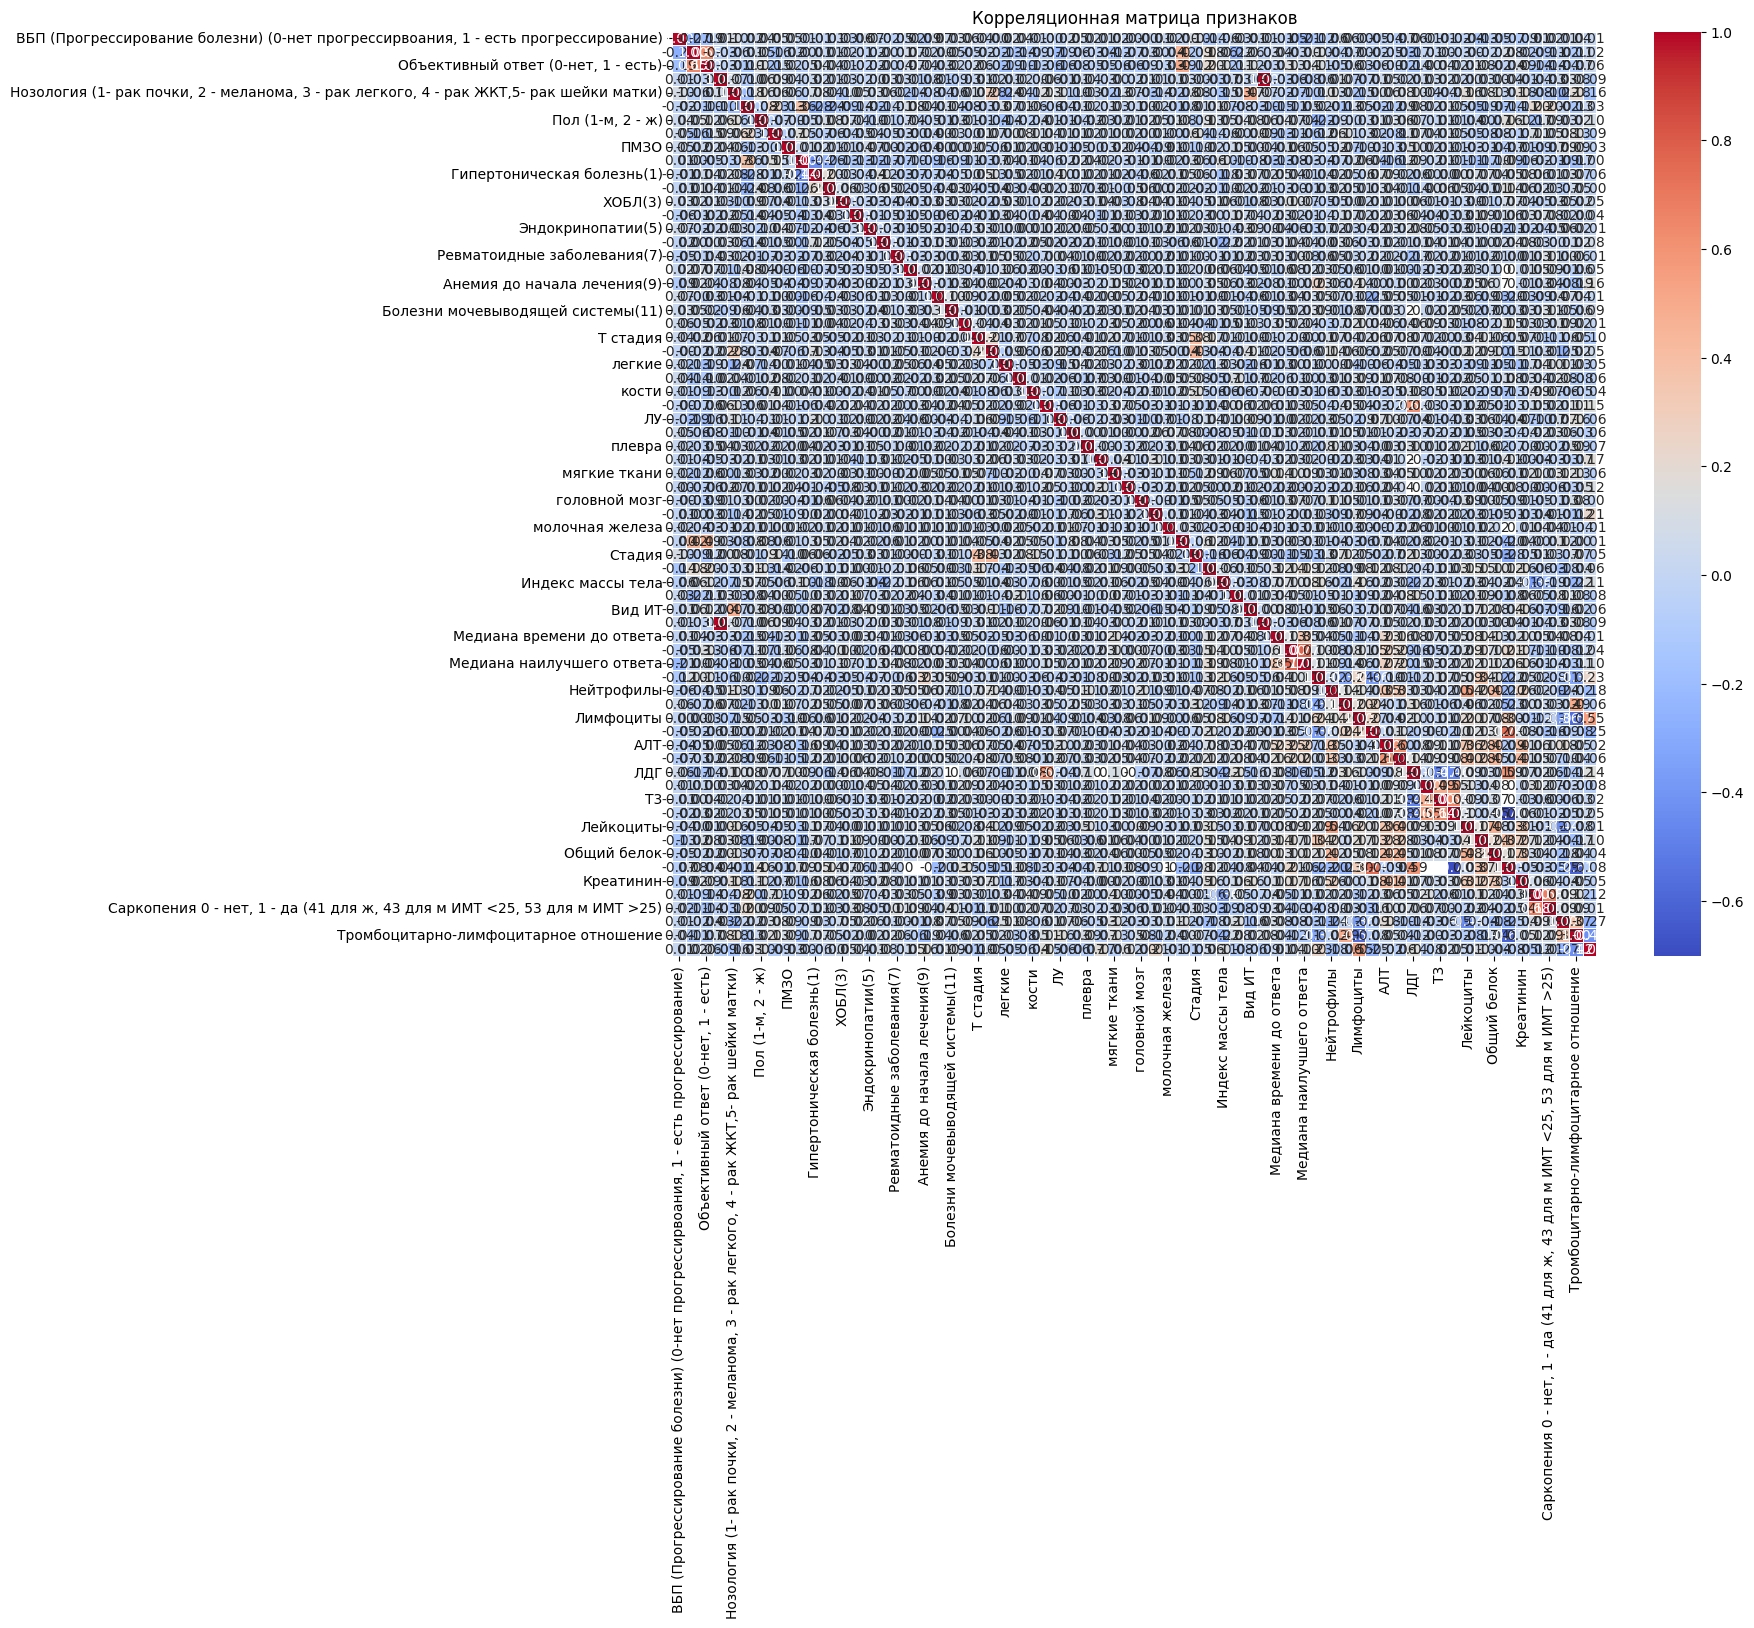

In [169]:
cat_cols = data.select_dtypes(include=['object']).columns
data1 = data.copy()
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data1[col] = data1[col].astype(str)
    data1[col] = le.fit_transform(data1[col])
    label_encoders[col] = le

corr_matrix = data1.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Корреляционная матрица признаков")
plt.show()

Посмотрим подробнее на пропуски и попробуем с ними что-то сделать

In [170]:
missing_percent = data.isnull().mean() * 100
high_missing = missing_percent[missing_percent > 50]

print("Признаки с более чем 50% пропущенных значений:")
for col, percent in high_missing.items():
    print(f"{col}: {percent:.2f}%")

Признаки с более чем 50% пропущенных значений:
Нейтрофилы: 54.45%
Лимфоциты: 75.82%
Моноциты: 75.82%
ЛДГ: 92.01%
ТТГ: 97.30%
Т3: 98.60%
Т4: 98.20%
Эритроциты: 55.74%
Альбумин: 94.01%
Саркопения (0 - нет, 1 - да), критерии Prado (ж - <38,5, м- <52,4): 68.83%
Саркопения 0 - нет, 1 - да (41 для ж, 43 для м ИМТ <25, 53 для м ИМТ >25): 68.83%
Нейтрофильно-лимфоцитарное отношение: 75.82%
Тромбоцитарно-лимфоцитарное отношение: 75.82%
Лимфоцитарно-моноцитарное отношение: 75.82%


Удалим те признаки, в которых пропущено более 50% значений, так как вряд ли они дадут нам какую-либо полезную информацию. Заполнив эти пропуски мы можем получить искаженное распределение, поэтому удаляем

In [171]:
data = data.drop(columns=high_missing.index)

print(f"Удалено {len(high_missing)} признаков с более чем 50% пропусков.")
print(f"Размер данных после удаления: {data.shape}")

Удалено 14 признаков с более чем 50% пропусков.
Размер данных после удаления: (1001, 54)


Преобразуем столбцы типа object в числовой тип

In [172]:
object_cols = data.select_dtypes(include=['object']).columns

for col in object_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

Сразу проверим уникальные значения в целевых столбцах:
- ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)
- КЗ (Контроль заболевания) (0-нет, 1 - есть)
- Объективный ответ (0-нет, 1 - есть)
- Токсичность 3-4

In [173]:
columns_to_check = [
    'ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)',
    'КЗ (Контроль заболевания) (0-нет, 1 - есть)',
    'Объективный ответ (0-нет, 1 - есть)',
    'Токсичность 3-4'
]

for column in columns_to_check:
    unique_values = data[column].unique()
    print(f"{column}: уникальные значения - {unique_values}")

ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование): уникальные значения - [0 1]
КЗ (Контроль заболевания) (0-нет, 1 - есть): уникальные значения - [1 0 2]
Объективный ответ (0-нет, 1 - есть): уникальные значения - [0 1 2]
Токсичность 3-4: уникальные значения - [0 1]


В бинарных признаках Контроль заболевания и Токсичность, которые подразумевают значения 0 и 1, откуда-то взялись значения 2. Заменим их на 1, предполагается, что это просто ошибки или опечатки. Так как не 0, значит скорее всего подрузумевалось наличие контроля и токсичности

In [174]:
columns_to_fix = ['КЗ (Контроль заболевания) (0-нет, 1 - есть)', 'Объективный ответ (0-нет, 1 - есть)']
for column in columns_to_fix:
    data[column] = data[column].replace(2, 1)

for column in columns_to_fix:
    print(f"Уникальные значения в столбце {column}: {data[column].unique()}")

Уникальные значения в столбце КЗ (Контроль заболевания) (0-нет, 1 - есть): [1 0]
Уникальные значения в столбце Объективный ответ (0-нет, 1 - есть): [0 1]


Прежде всего, чтобы заполнить пропуски, нам нужно определить, какие из признаков являются категориальными (бинарными или порядковыми), а какие численными. Определять это будем по количеству уникальных значений в каждом столбце

In [175]:
unique_counts = data.nunique()
categorical_cols = [col for col in data.columns if (unique_counts[col] <= 15)]

print("Категориальные признаки:")
print(categorical_cols)

Категориальные признаки:
['ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)', 'КЗ (Контроль заболевания) (0-нет, 1 - есть)', 'Объективный ответ (0-нет, 1 - есть)', 'Токсичность 3-4', 'Нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак ЖКТ,5- рак шейки матки)', 'Пол (1-м, 2 - ж)', 'ECOG', 'ПМЗО', 'Сопутствующие. Наличие', 'Гипертоническая болезнь(1)', 'ИБС(2)', 'ХОБЛ(3)', 'Мерц аритмия(4)', 'Эндокринопатии(5)', 'СД(6)', 'Ревматоидные заболевания(7)', 'Гепатиты(8)', 'Анемия до начала лечения(9)', 'Гастроэнтериты(10)', 'Болезни мочевыводящей системы(11)', 'Варикозное расширение вен(12)', 'Т стадия', 'N стадия', 'легкие', 'печень', 'кости', 'брюшная полость', 'ЛУ', 'надпочечники', 'плевра', 'почки', 'мягкие ткани', 'яичники', 'головной мозг', 'поджелудочная железа', 'молочная железа', 'Характер метастазирования', 'Стадия', 'Мутация гена BRAF', 'Линия иммунотерапии', 'Вид ИТ', 'Токсичность 3-4.1']


In [176]:
for col in categorical_cols:
    unique_vals = data[col].dropna().unique()
    n_unique = len(unique_vals)

    if n_unique == 2:
        print(f"{col}: бинарный признак")

    elif pd.api.types.is_numeric_dtype(data[col]):
        if n_unique <= 10:
            print(f"{col}: номинальный признак")
        else:
            print(f"{col}: другое")

ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование): бинарный признак
КЗ (Контроль заболевания) (0-нет, 1 - есть): бинарный признак
Объективный ответ (0-нет, 1 - есть): бинарный признак
Токсичность 3-4: бинарный признак
Нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак ЖКТ,5- рак шейки матки): номинальный признак
Пол (1-м, 2 - ж): бинарный признак
ECOG: номинальный признак
ПМЗО: бинарный признак
Сопутствующие. Наличие: бинарный признак
Гипертоническая болезнь(1): бинарный признак
ИБС(2): бинарный признак
ХОБЛ(3): бинарный признак
Мерц аритмия(4): бинарный признак
Эндокринопатии(5): бинарный признак
СД(6): бинарный признак
Ревматоидные заболевания(7): бинарный признак
Гепатиты(8): бинарный признак
Анемия до начала лечения(9): бинарный признак
Гастроэнтериты(10): бинарный признак
Болезни мочевыводящей системы(11): бинарный признак
Варикозное расширение вен(12): бинарный признак
Т стадия: номинальный признак
N стадия: номинальный признак
легкие

Теперь, когда мы знаем какие признаки у нас непрерывные, бинарные или номинальные (порядковые) - можно заполнить пропущенные значения
- Для непрерывных признаков - заполняем средним
- Для бинарных - заполняем модой
- Для номинальных - заполняем медианой

In [177]:
data.columns = data.columns.str.strip().str.lower()

binary_cols = [col.lower().strip() for col in [
    'ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)',
    'Токсичность 3-4', 'Пол (1-м, 2 - ж)', 'ПМЗО', 'Сопутствующие. Наличие',
    'Гипертоническая болезнь(1)', 'ИБС(2)', 'ХОБЛ(3)', 'Мерц аритмия(4)',
    'Эндокринопатии(5)', 'СД(6)', 'Ревматоидные заболевания(7)', 'Гепатиты(8)',
    'Анемия до начала лечения(9)', 'Гастроэнтериты(10)', 'Болезни мочевыводящей системы(11)',
    'Варикозное расширение вен(12)', 'легкие', 'печень', 'кости', 'брюшная полость',
    'лу', 'надпочечники', 'плевра', 'почки', 'мягкие ткани', 'яичники', 'головной мозг',
    'поджелудочная железа', 'молочная железа', 'токсичность 3-4.1'
]]

ordinal_cols = [col.lower().strip() for col in [
    'кз (контроль заболевания) (0-нет, 1 - есть)', 'объективный ответ (0-нет, 1 - есть)',
    'нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки)',
    'ecog', 'т стадия', 'n стадия', 'характер метастазирования', 'стадия',
    'мутация гена braf', 'линия иммунотерапии', 'вид ит'
]]

numeric_cols = [col.lower().strip() for col in [
    'возраст', 'индекс массы тела', 'медиана времени до ответа', 'медиана длительности ответа',
    'медиана наилучшего ответа', 'гемоглобин', 'нейтрофилы', 'тромбоциты', 'лимфоциты',
    'моноциты', 'алт', 'аст', 'лдг', 'ттг', 'т3', 'т4', 'лейкоциты', 'эритроциты',
    'общий белок', 'альбумин', 'креатинин', 'нейтрофильно-лимфоцитарное отношение',
    'тромбоцитарно-лимфоцитарное отношение', 'лимфоцитарно-моноцитарное отношение'
]]

for col in binary_cols:
    if col in data.columns:
        mode_val = data[col].mode()[0]
        data[col] = data[col].fillna(mode_val)

for col in ordinal_cols:
    if col in data.columns:
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)

for col in numeric_cols:
    if col in data.columns:
        mean_val = data[col].mean()
        data[col] = data[col].fillna(mean_val)

Далее выделим целевые признаки, разделим данные и нормализуем

И наши данные готовы для обучения моделей!

In [178]:
data['target_вбп'] = data['вбп (прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)'].astype(int)
data['target_кз'] = data['кз (контроль заболевания) (0-нет, 1 - есть)'].astype(int)
data['target_объективный_ответ'] = data['объективный ответ (0-нет, 1 - есть)'].astype(int)
data['target_токсичность'] = data['токсичность 3-4'].astype(int)

exclude_cols = [
    'вбп (прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)',
    'кз (контроль заболевания) (0-нет, 1 - есть)',
    'объективный ответ (0-нет, 1 - есть)',
    'токсичность 3-4',
    'target_вбп', 'target_кз', 'target_объективный_ответ', 'target_токсичность'
]

feature_columns = [col for col in data.columns if col not in exclude_cols]
features = data[feature_columns]

scaler = StandardScaler()
numeric_present = [col for col in numeric_cols if col in features.columns]

features_numeric_scaled = scaler.fit_transform(features[numeric_present])

features.loc[:, numeric_present] = features.loc[:, numeric_present].astype(float)
features.loc[:, numeric_present] = features_numeric_scaled


target_columns = ['target_вбп', 'target_кз', 'target_объективный_ответ', 'target_токсичность']
targets = data[target_columns]

C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\2454793960.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.11427255 -0.77882925 -0.94496843 ...  0.38414498  0.79949292
 -0.69575967]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  features.loc[:, numeric_present] = features_numeric_scaled


### Шаг 2: Построение модели

Соберем нашу рабочую модель, объявим класс, напишем все необходимые функции. Так как классы у нас в большинстве несбалансированные - будем использовать pos_weight

In [179]:
class MedicalNN(nn.Module):
    def __init__(self, input_size):
        super(MedicalNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train_model(model, X_train, y_train, optimizer, scheduler=None, epochs=20):
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight = torch.tensor(n_neg.float() / n_pos.float())
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print(f"pos_weight: {pos_weight.item():.2f}")

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).int()

    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    y_test_np = y_test.numpy()
    probs_np = probs.numpy()

    fpr, tpr, _ = roc_curve(y_test_np, probs_np)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    precision_curve, recall_curve, _ = precision_recall_curve(y_test_np, probs_np)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure(figsize=(6,4))
    plt.plot(recall_curve, precision_curve, label=f'AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    return preds, probs


def prepare_data(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)
    X_train = torch.tensor(X_train.values).float()
    X_test = torch.tensor(X_test.values).float()
    y_train = torch.tensor(y_train.values).float()
    y_test = torch.tensor(y_test.values).float()
    return X_train, X_test, y_train, y_test



def run_pipeline(features, target, feature_names, target_name, epochs=20):
    X_train, X_test, y_train, y_test = prepare_data(features, target)

    input_size = features.shape[1]
    model = MedicalNN(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_model(model, X_train, y_train, optimizer, scheduler, epochs)

    preds, probs = evaluate_model(model, X_test, y_test)

    analyze_model_all_methods(model, features.values if hasattr(features, 'values') else features, target.values if hasattr(target, 'values') else target, feature_names)

    return model

Далее напишем функции для оценки важности признаков (реализация методов анализа модели)

In [180]:
def compute_gradcam_fcn(model, x):
    model.eval()
    x = x.unsqueeze(0).float().requires_grad_(True)
    output = model(x).squeeze()
    model.zero_grad()
    output.backward()

    gradients = x.grad[0]
    cam = gradients.detach().cpu().numpy()
    return cam

def shap_analys(model, X_train, X_test, feature_names, n_samples=50, max_display=15):
    background = X_train[:100] if isinstance(X_train, np.ndarray) else X_train.values[:100]
    test_samples = X_test[:n_samples] if isinstance(X_test, np.ndarray) else X_test.values[:n_samples]

    explainer = shap.Explainer(
        lambda x: torch.sigmoid(model(torch.tensor(x).float())).detach().numpy(),
        background,
        feature_names=feature_names
    )
    shap_values = explainer(test_samples)

    plt.figure(figsize=(12, max(6, max_display/2)))
    shap.summary_plot(shap_values.values, test_samples, feature_names=feature_names, max_display=max_display, plot_type='dot', show=False)
    plt.title(f'SHAP значения (топ-{max_display} признаков)', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, max(4, max_display/3)))
    shap.plots.bar(shap_values, max_display=max_display, show=False)
    plt.title(f'Средняя важность признаков (топ-{max_display})', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    return shap_values


def rfe_feature_importance(features, target, feature_names):
    model_rfe = LogisticRegression(max_iter=1000)
    rfe = RFE(model_rfe, n_features_to_select=1)
    rfe.fit(features, target)

    ranking = rfe.ranking_
    importance = dict(zip(feature_names, ranking))

    print("Ранжирование признаков по важности (RFE):")
    for feature, rank in sorted(importance.items(), key=lambda x: x[1]):
        print(f"{feature}: {rank}")

def decision_tree_analysis(features, target, feature_names):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
    tree_model.fit(X_train, y_train)

    accuracy = tree_model.score(X_test, y_test)
    print(f"Точность дерева решений: {accuracy:.4f}")

    plt.figure(figsize=(12, 8))
    plot_tree(tree_model, feature_names=feature_names, class_names=['No', 'Yes'], filled=True)
    plt.title("Дерево решений")
    plt.show()

    feature_importances = tree_model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    top_n = 10
    top_indices = indices[:top_n]
    sorted_features = [feature_names[i] for i in top_indices]
    sorted_importances = feature_importances[top_indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importances, y=sorted_features)
    plt.title(f"Значимость признаков (Decision Tree) — топ-{top_n}")
    plt.xlabel("Важность")
    plt.ylabel("Признаки")
    plt.show()

    print("\nТоп-10 признаков по важности:")
    for feature, importance in zip(sorted_features, sorted_importances):
        print(f"Признак: {feature}, Значимость: {importance:.4f}")


def analyze_model_all_methods(model, features, target, feature_names, target_class=1):
    print("Grad-CAM")
    x_example = torch.tensor(features[0]).float()
    cam_result = compute_gradcam_fcn(model, x_example)
    for f_name, cam_val in zip(feature_names, cam_result):
        print(f"{f_name}: {cam_val:.4f}")

    print("\nSHAP")
    shap_analys(model, features, features, feature_names)

    print("\nRFE")
    rfe_feature_importance(features, target, feature_names)

    print("\nDecision Tree")
    decision_tree_analysis(features, target, feature_names)

### Таргет ВБП (Прогрессирование болезни)

In [181]:
data['target_вбп'].value_counts()

target_вбп
0    694
1    307
Name: count, dtype: int64

C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\1902312598.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(n_neg.float() / n_pos.float())


pos_weight: 2.27
Epoch 5/50, Loss: 0.9522
Epoch 10/50, Loss: 0.9485
Epoch 15/50, Loss: 0.9459
Epoch 20/50, Loss: 0.9441
Epoch 25/50, Loss: 0.9432
Epoch 30/50, Loss: 0.9428
Epoch 35/50, Loss: 0.9425
Epoch 40/50, Loss: 0.9424
Epoch 45/50, Loss: 0.9424
Epoch 50/50, Loss: 0.9424
Accuracy: 0.5373, Precision: 0.3719, Recall: 0.7258, F1-score: 0.4918


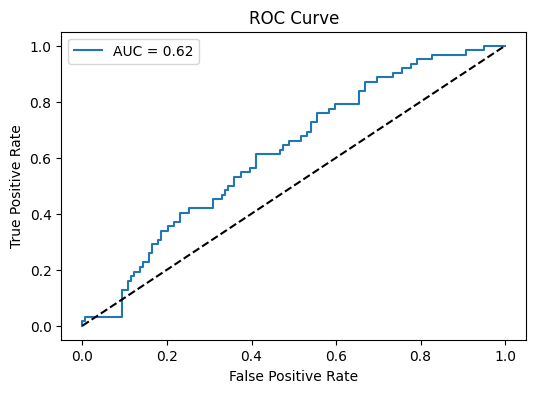

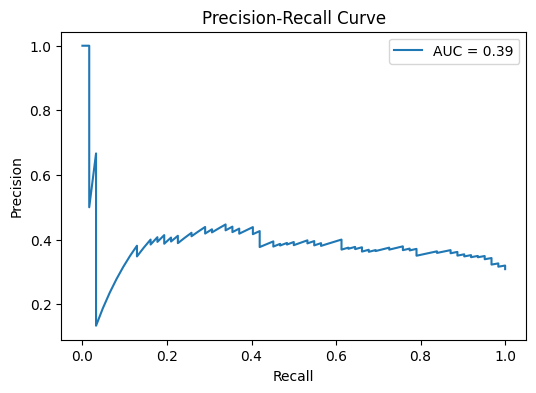

Grad-CAM
нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки): 0.0400
возраст: 0.0142
пол (1-м, 2 - ж): -0.0048
ecog: -0.0002
пмзо: 0.0002
сопутствующие. наличие: 0.0120
гипертоническая болезнь(1): -0.0108
ибс(2): -0.0054
хобл(3): 0.0093
мерц аритмия(4): -0.0199
эндокринопатии(5): -0.0058
сд(6): 0.0180
ревматоидные заболевания(7): -0.0108
гепатиты(8): 0.0120
анемия до начала лечения(9): 0.0004
гастроэнтериты(10): -0.0028
болезни мочевыводящей системы(11): 0.0049
варикозное расширение вен(12): -0.0062
т стадия: -0.0002
n стадия: 0.0073
легкие: 0.0130
печень: -0.0089
кости: -0.0010
брюшная полость: 0.0161
лу: -0.0172
надпочечники: -0.0078
плевра: 0.0107
почки: 0.0259
мягкие ткани: -0.0203
яичники: 0.0135
головной мозг: 0.0015
поджелудочная железа: -0.0148
молочная железа: 0.0216
характер метастазирования: 0.0021
стадия: 0.0083
мутация гена braf: -0.0128
индекс массы тела: -0.0252
линия иммунотерапии: 0.0120
вид ит: -0.0149
токсичность 3-4.1: 0.0336
меди

C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\3625154978.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, test_samples, feature_names=feature_names, max_display=max_display, plot_type='dot', show=False)
C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\3625154978.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


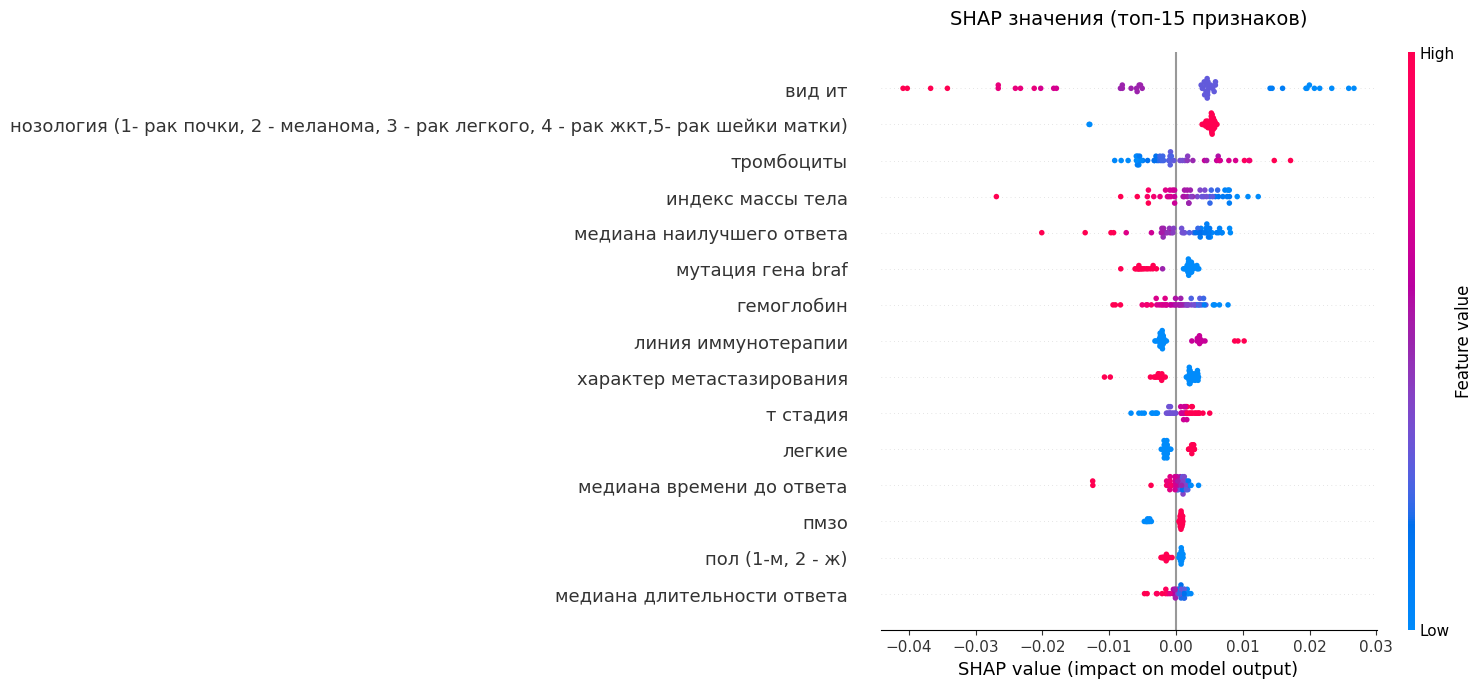

C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\3625154978.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


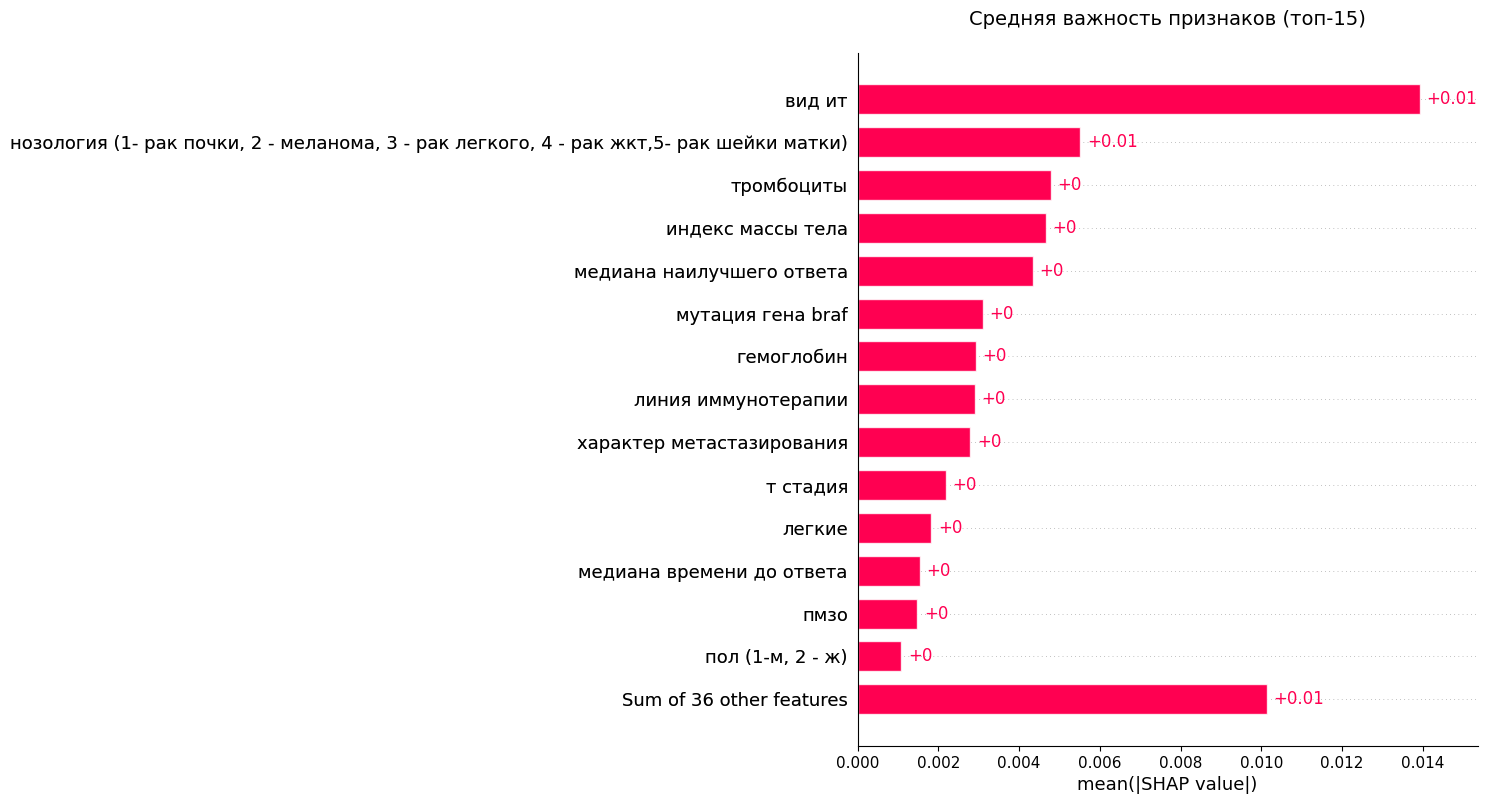


RFE
Ранжирование признаков по важности (RFE):
аст: 1
алт: 2
анемия до начала лечения(9): 3
эндокринопатии(5): 4
варикозное расширение вен(12): 5
гастроэнтериты(10): 6
медиана наилучшего ответа: 7
мерц аритмия(4): 8
медиана длительности ответа: 9
надпочечники: 10
пмзо: 11
ревматоидные заболевания(7): 12
болезни мочевыводящей системы(11): 13
мутация гена braf: 14
мягкие ткани: 15
плевра: 16
пол (1-м, 2 - ж): 17
гепатиты(8): 18
печень: 19
медиана времени до ответа: 20
хобл(3): 21
стадия: 22
сопутствующие. наличие: 23
нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки): 24
n стадия: 25
сд(6): 26
токсичность 3-4.1: 27
гемоглобин: 28
легкие: 29
яичники: 30
общий белок: 31
поджелудочная железа: 32
индекс массы тела: 33
брюшная полость: 34
молочная железа: 35
гипертоническая болезнь(1): 36
вид ит: 37
кости: 38
лу: 39
ecog: 40
лейкоциты: 41
креатинин: 42
тромбоциты: 43
почки: 44
т стадия: 45
возраст: 46
ибс(2): 47
головной мозг: 48
характер метастазирования:

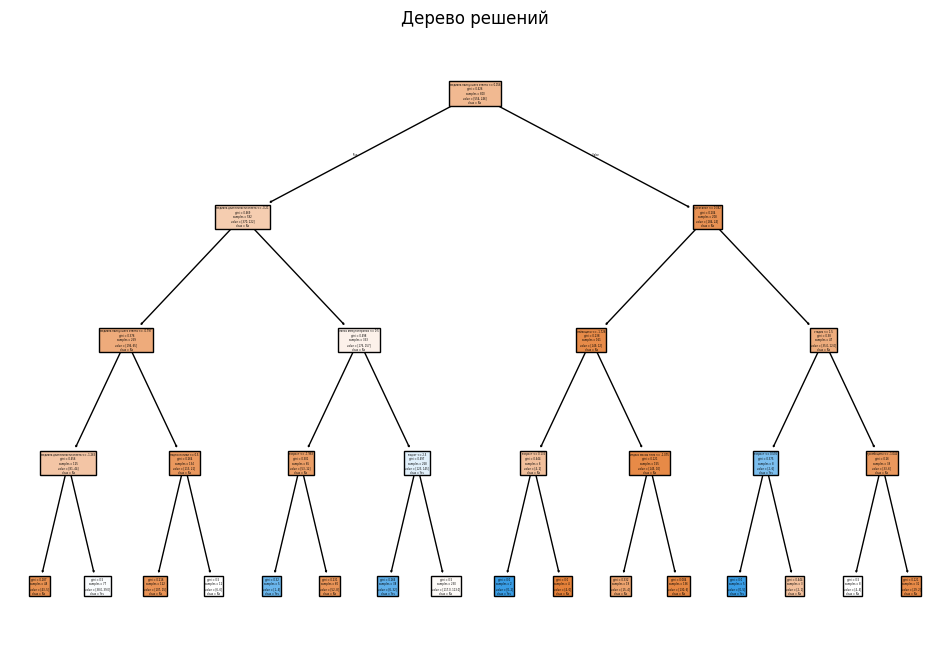

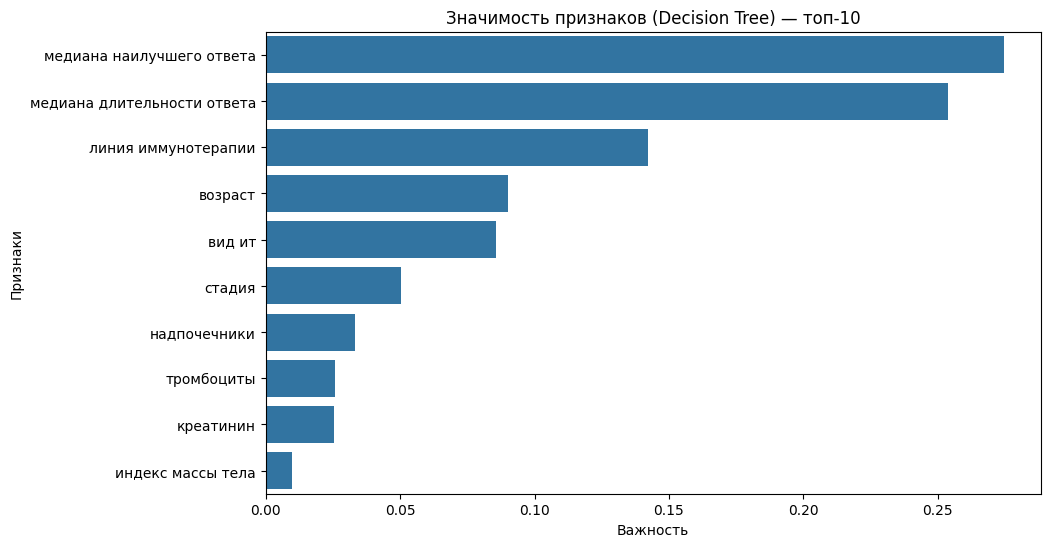


Топ-10 признаков по важности:
Признак: медиана наилучшего ответа, Значимость: 0.2745
Признак: медиана длительности ответа, Значимость: 0.2538
Признак: линия иммунотерапии, Значимость: 0.1421
Признак: возраст, Значимость: 0.0902
Признак: вид ит, Значимость: 0.0858
Признак: стадия, Значимость: 0.0504
Признак: надпочечники, Значимость: 0.0332
Признак: тромбоциты, Значимость: 0.0258
Признак: креатинин, Значимость: 0.0254
Признак: индекс массы тела, Значимость: 0.0099


MedicalNN(
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [182]:
target = data['target_вбп']
run_pipeline(features, target, feature_columns, 'target_вбп', epochs=50)

### Таргет Контроль заболевания

In [183]:
data['target_кз'].value_counts()

target_кз
1    820
0    181
Name: count, dtype: int64

pos_weight: 0.22
Epoch 5/50, Loss: 0.2505
Epoch 10/50, Loss: 0.2451
Epoch 15/50, Loss: 0.2426
Epoch 20/50, Loss: 0.2414
Epoch 25/50, Loss: 0.2408
Epoch 30/50, Loss: 0.2405
Epoch 35/50, Loss: 0.2403


C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\1902312598.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(n_neg.float() / n_pos.float())


Epoch 40/50, Loss: 0.2403
Epoch 45/50, Loss: 0.2402
Epoch 50/50, Loss: 0.2402
Accuracy: 0.7811, Precision: 0.9007, Recall: 0.8242, F1-score: 0.8608


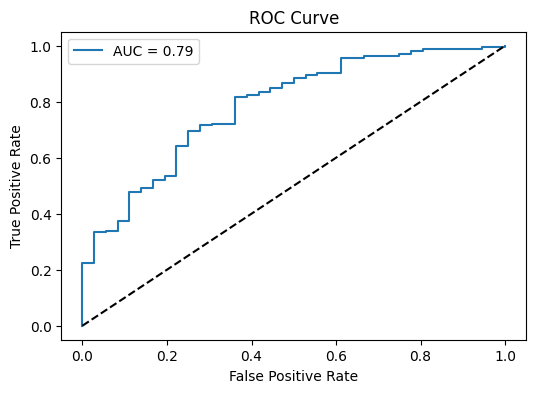

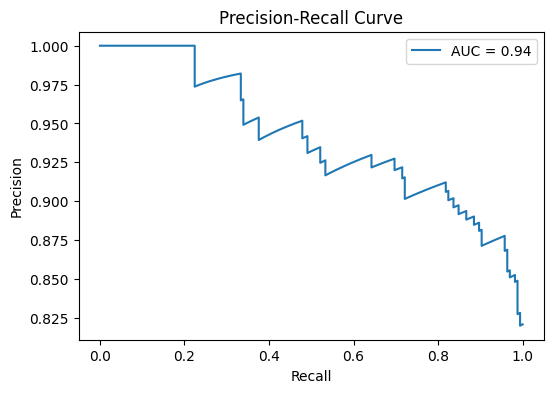

Grad-CAM
нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки): 0.0239
возраст: 0.0085
пол (1-м, 2 - ж): -0.0169
ecog: -0.0251
пмзо: 0.0061
сопутствующие. наличие: 0.0367
гипертоническая болезнь(1): 0.0196
ибс(2): 0.0013
хобл(3): 0.0068
мерц аритмия(4): -0.0099
эндокринопатии(5): -0.0041
сд(6): -0.0179
ревматоидные заболевания(7): -0.0298
гепатиты(8): -0.0264
анемия до начала лечения(9): -0.0398
гастроэнтериты(10): 0.0167
болезни мочевыводящей системы(11): -0.0203
варикозное расширение вен(12): -0.0445
т стадия: 0.0071
n стадия: -0.0022
легкие: -0.0100
печень: -0.0286
кости: -0.0333
брюшная полость: 0.0531
лу: -0.0309
надпочечники: 0.0083
плевра: 0.0181
почки: -0.0470
мягкие ткани: -0.0237
яичники: -0.0285
головной мозг: -0.0498
поджелудочная железа: 0.0240
молочная железа: -0.0234
характер метастазирования: 0.0074
стадия: 0.0239
мутация гена braf: -0.0380
индекс массы тела: 0.0395
линия иммунотерапии: -0.0320
вид ит: 0.0545
токсичность 3-4.1: 0.0120
м

C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\3625154978.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, test_samples, feature_names=feature_names, max_display=max_display, plot_type='dot', show=False)


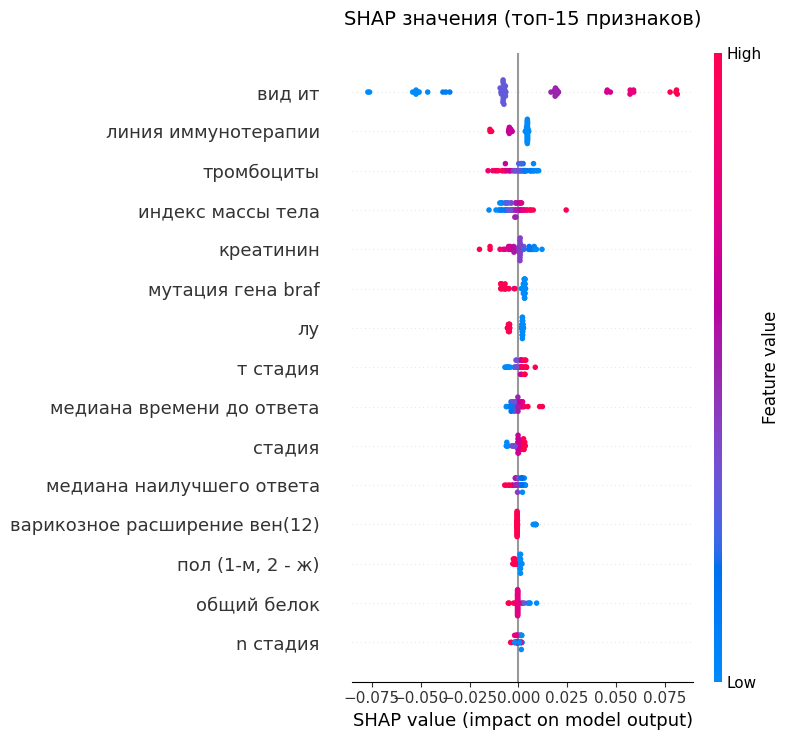

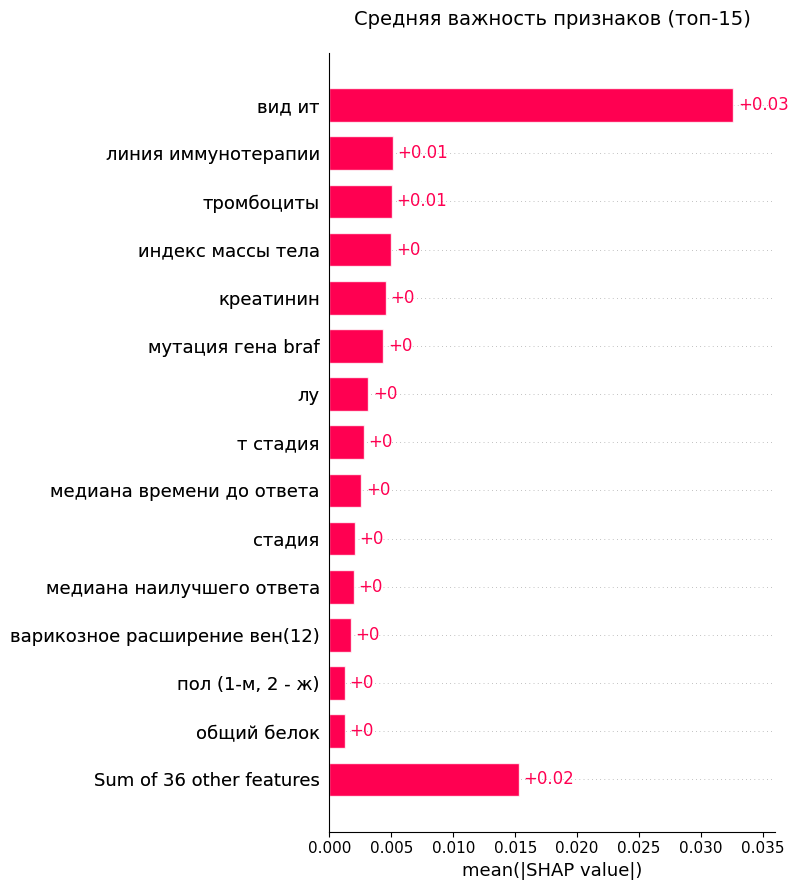


RFE
Ранжирование признаков по важности (RFE):
варикозное расширение вен(12): 1
яичники: 2
мягкие ткани: 3
печень: 4
поджелудочная железа: 5
гепатиты(8): 6
молочная железа: 7
характер метастазирования: 8
болезни мочевыводящей системы(11): 9
пмзо: 10
ecog: 11
почки: 12
сд(6): 13
сопутствующие. наличие: 14
кости: 15
лу: 16
брюшная полость: 17
эндокринопатии(5): 18
плевра: 19
хобл(3): 20
вид ит: 21
пол (1-м, 2 - ж): 22
мутация гена braf: 23
токсичность 3-4.1: 24
гастроэнтериты(10): 25
ревматоидные заболевания(7): 26
надпочечники: 27
легкие: 28
анемия до начала лечения(9): 29
аст: 30
тромбоциты: 31
лейкоциты: 32
т стадия: 33
креатинин: 34
головной мозг: 35
возраст: 36
ибс(2): 37
медиана времени до ответа: 38
стадия: 39
нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки): 40
мерц аритмия(4): 41
линия иммунотерапии: 42
общий белок: 43
алт: 44
гемоглобин: 45
медиана наилучшего ответа: 46
гипертоническая болезнь(1): 47
медиана длительности ответа: 48
индекс 

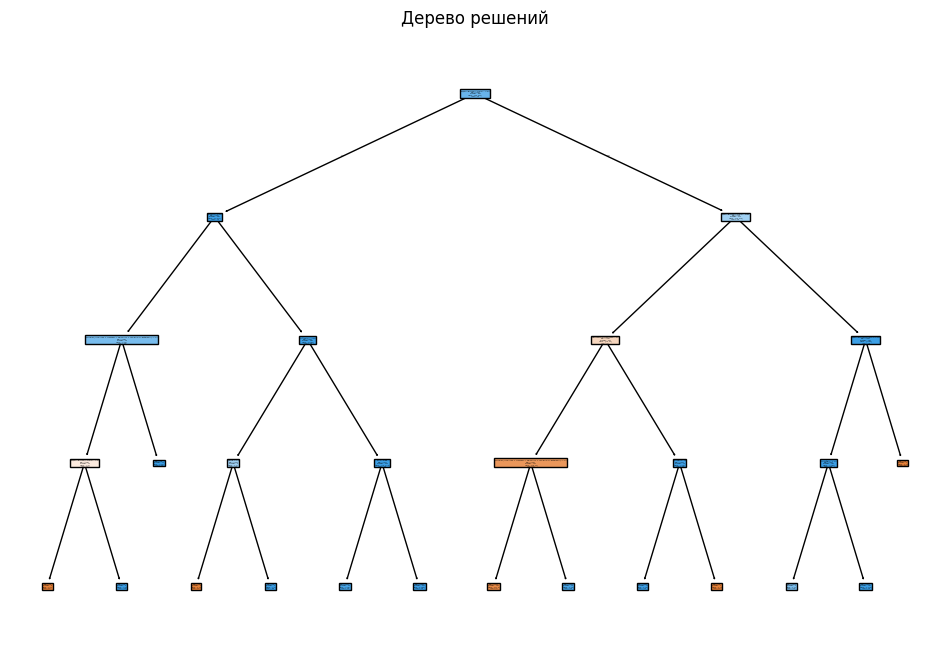

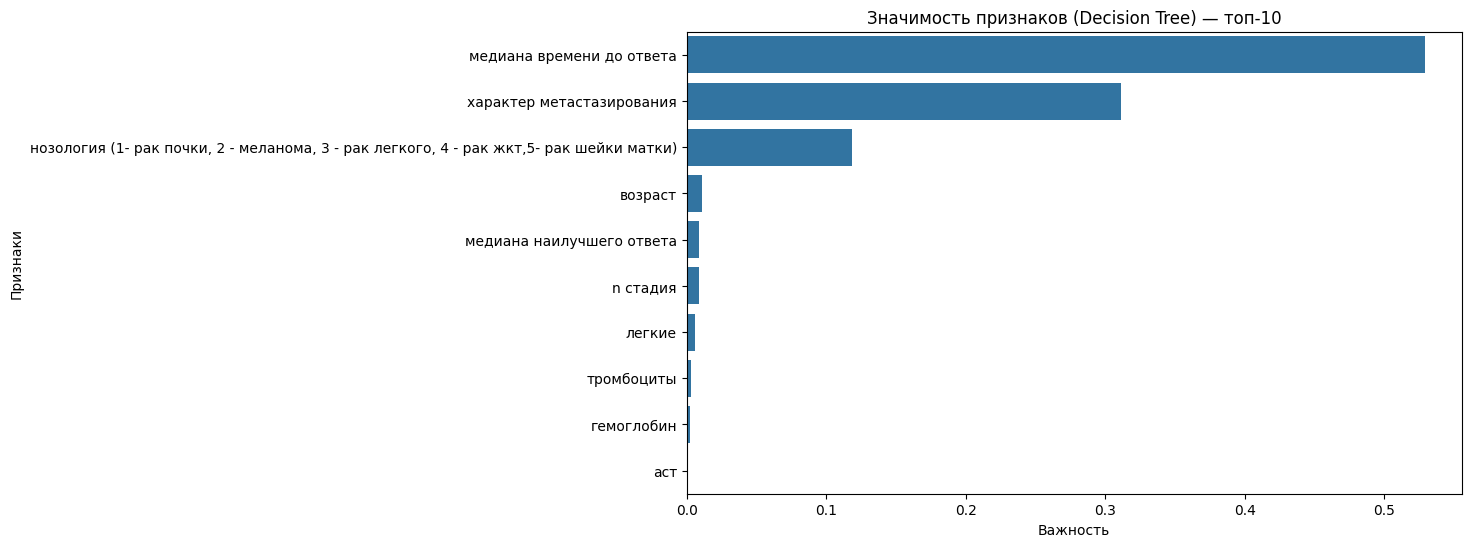


Топ-10 признаков по важности:
Признак: медиана времени до ответа, Значимость: 0.5291
Признак: характер метастазирования, Значимость: 0.3113
Признак: нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки), Значимость: 0.1186
Признак: возраст, Значимость: 0.0112
Признак: медиана наилучшего ответа, Значимость: 0.0089
Признак: n стадия, Значимость: 0.0088
Признак: легкие, Значимость: 0.0061
Признак: тромбоциты, Значимость: 0.0029
Признак: гемоглобин, Значимость: 0.0021
Признак: аст, Значимость: 0.0009


MedicalNN(
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [184]:
target = data['target_кз']
target_binary = (target > 0).astype(int)
run_pipeline(features, target_binary, feature_columns, 'target_кз', epochs=50)

### Таргет Объективный ответ

In [185]:
data['target_объективный_ответ'].value_counts()

target_объективный_ответ
0    687
1    314
Name: count, dtype: int64

pos_weight: 2.19
Epoch 5/50, Loss: 0.9440
Epoch 10/50, Loss: 0.9350
Epoch 15/50, Loss: 0.9308
Epoch 20/50, Loss: 0.9284
Epoch 25/50, Loss: 0.9271
Epoch 30/50, Loss: 0.9265
Epoch 35/50, Loss: 0.9261


C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\1902312598.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(n_neg.float() / n_pos.float())


Epoch 40/50, Loss: 0.9260
Epoch 45/50, Loss: 0.9259
Epoch 50/50, Loss: 0.9258
Accuracy: 0.5771, Precision: 0.3942, Recall: 0.6508, F1-score: 0.4910


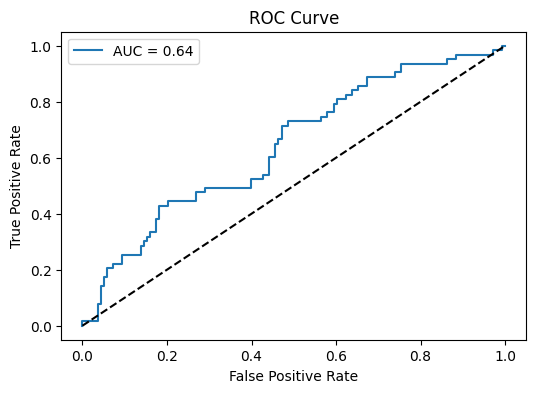

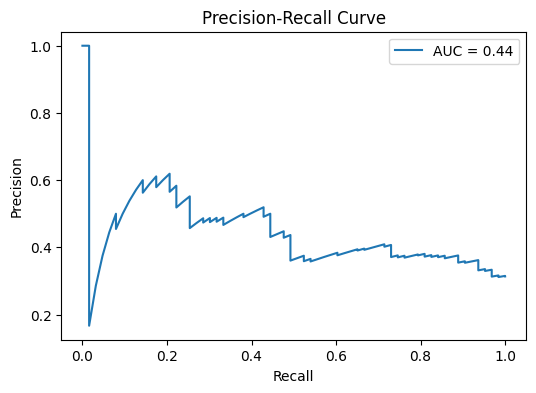

Grad-CAM
нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки): 0.0097
возраст: -0.0520
пол (1-м, 2 - ж): 0.0293
ecog: -0.0145
пмзо: 0.0128
сопутствующие. наличие: -0.0253
гипертоническая болезнь(1): -0.0162
ибс(2): -0.0051
хобл(3): 0.0128
мерц аритмия(4): -0.0001
эндокринопатии(5): 0.0030
сд(6): -0.0095
ревматоидные заболевания(7): 0.0406
гепатиты(8): -0.0001
анемия до начала лечения(9): 0.0062
гастроэнтериты(10): 0.0066
болезни мочевыводящей системы(11): -0.0096
варикозное расширение вен(12): 0.0103
т стадия: 0.0033
n стадия: -0.0160
легкие: -0.0143
печень: 0.0129
кости: -0.0088
брюшная полость: -0.0137
лу: -0.0168
надпочечники: -0.0220
плевра: -0.0319
почки: -0.0112
мягкие ткани: -0.0168
яичники: 0.0321
головной мозг: -0.0116
поджелудочная железа: -0.0110
молочная железа: 0.0185
характер метастазирования: 0.0078
стадия: -0.0448
мутация гена braf: 0.0205
индекс массы тела: -0.0005
линия иммунотерапии: -0.0019
вид ит: -0.0067
токсичность 3-4.1: 0.0276

C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\3625154978.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, test_samples, feature_names=feature_names, max_display=max_display, plot_type='dot', show=False)


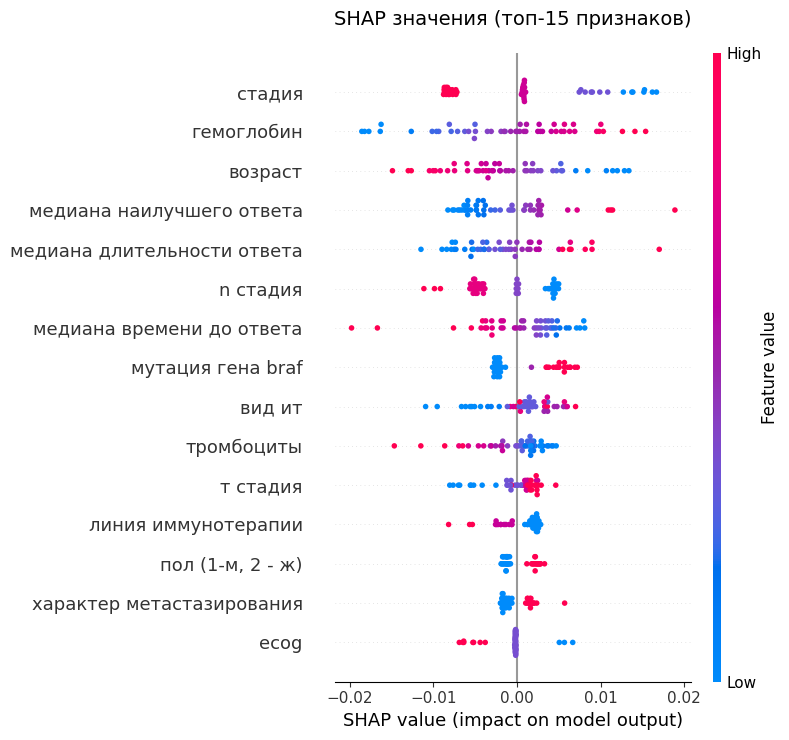

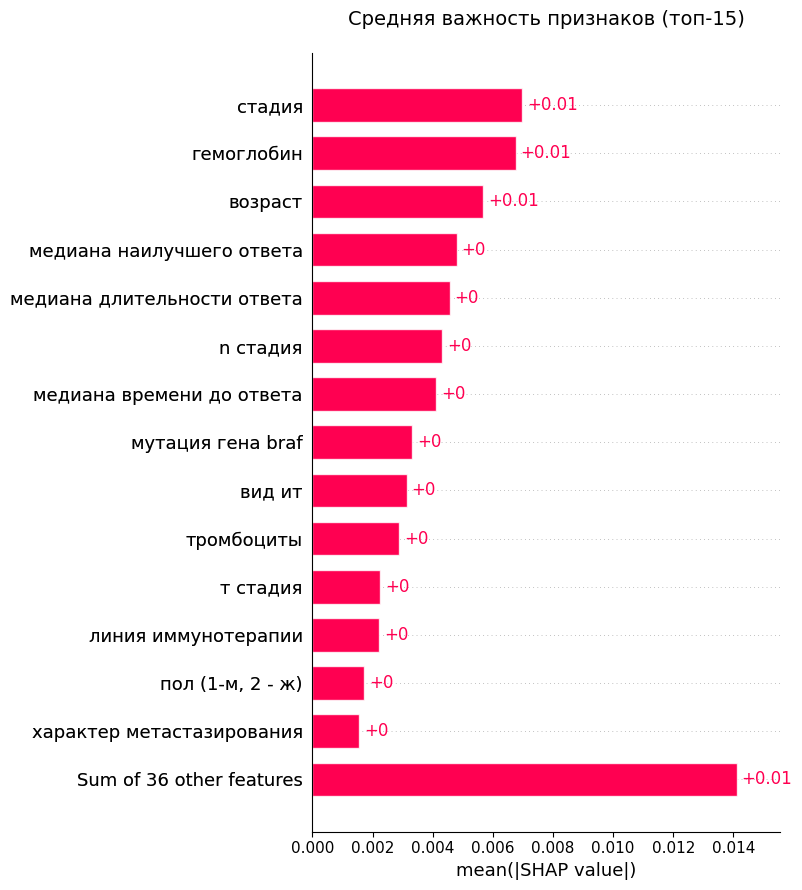


RFE
Ранжирование признаков по важности (RFE):
головной мозг: 1
яичники: 2
характер метастазирования: 3
кости: 4
гепатиты(8): 5
легкие: 6
ревматоидные заболевания(7): 7
мягкие ткани: 8
надпочечники: 9
печень: 10
плевра: 11
молочная железа: 12
почки: 13
брюшная полость: 14
сд(6): 15
лу: 16
эндокринопатии(5): 17
варикозное расширение вен(12): 18
ecog: 19
ибс(2): 20
мерц аритмия(4): 21
хобл(3): 22
медиана длительности ответа: 23
креатинин: 24
гастроэнтериты(10): 25
индекс массы тела: 26
поджелудочная железа: 27
анемия до начала лечения(9): 28
аст: 29
медиана времени до ответа: 30
токсичность 3-4.1: 31
возраст: 32
пмзо: 33
медиана наилучшего ответа: 34
мутация гена braf: 35
алт: 36
нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки): 37
болезни мочевыводящей системы(11): 38
гемоглобин: 39
стадия: 40
т стадия: 41
пол (1-м, 2 - ж): 42
гипертоническая болезнь(1): 43
общий белок: 44
n стадия: 45
линия иммунотерапии: 46
тромбоциты: 47
сопутствующие. наличие: 

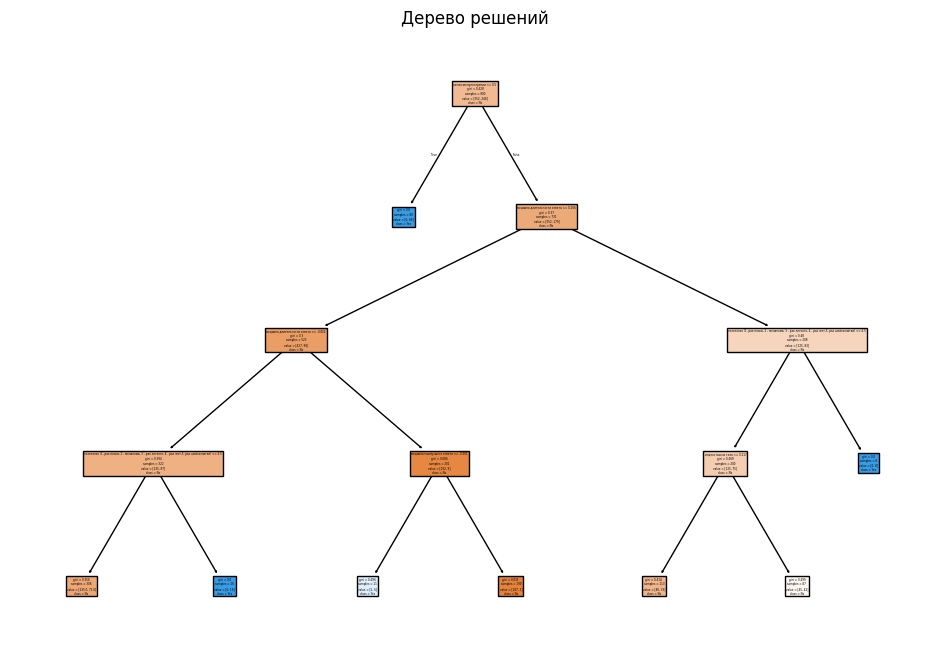

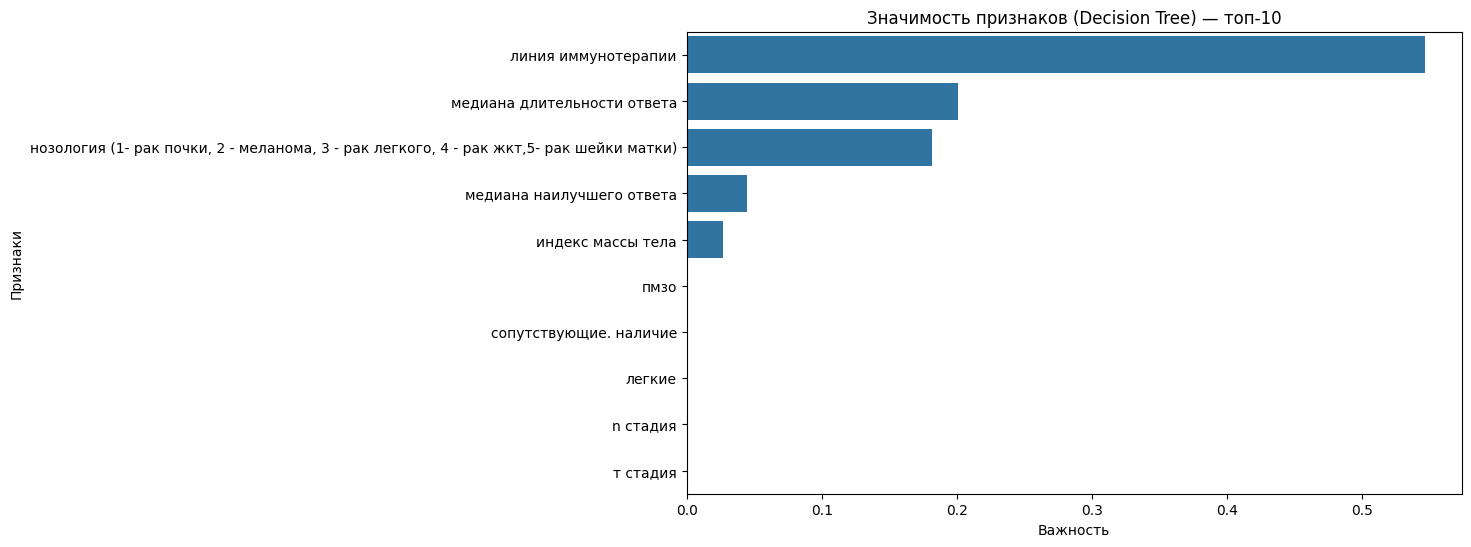


Топ-10 признаков по важности:
Признак: линия иммунотерапии, Значимость: 0.5462
Признак: медиана длительности ответа, Значимость: 0.2005
Признак: нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки), Значимость: 0.1819
Признак: медиана наилучшего ответа, Значимость: 0.0443
Признак: индекс массы тела, Значимость: 0.0272
Признак: пмзо, Значимость: 0.0000
Признак: сопутствующие. наличие, Значимость: 0.0000
Признак: легкие, Значимость: 0.0000
Признак: n стадия, Значимость: 0.0000
Признак: т стадия, Значимость: 0.0000


MedicalNN(
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [186]:

target = data['target_объективный_ответ']
target_binary = (target > 0).astype(int)
run_pipeline(features, target_binary, feature_columns, 'target_объективный_ответ', epochs=50)

In [187]:
data['target_токсичность'].value_counts()

target_токсичность
0    966
1     35
Name: count, dtype: int64

pos_weight: 27.57
Epoch 5/50, Loss: 1.3223
Epoch 10/50, Loss: 1.3075
Epoch 15/50, Loss: 1.2985
Epoch 20/50, Loss: 1.2932
Epoch 25/50, Loss: 1.2902
Epoch 30/50, Loss: 1.2887
Epoch 35/50, Loss: 1.2879
Epoch 40/50, Loss: 1.2875
Epoch 45/50, Loss: 1.2873
Epoch 50/50, Loss: 1.2872
Accuracy: 0.7960, Precision: 0.0526, Recall: 0.2857, F1-score: 0.0889


C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\1902312598.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(n_neg.float() / n_pos.float())


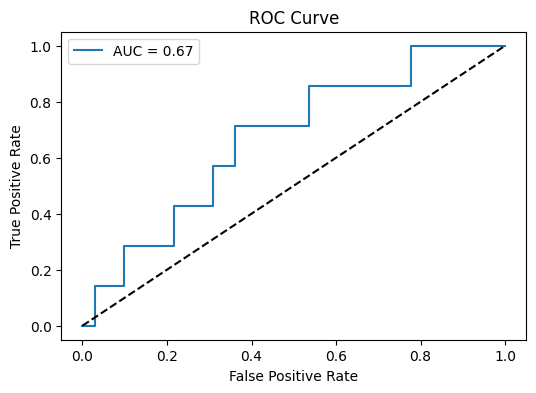

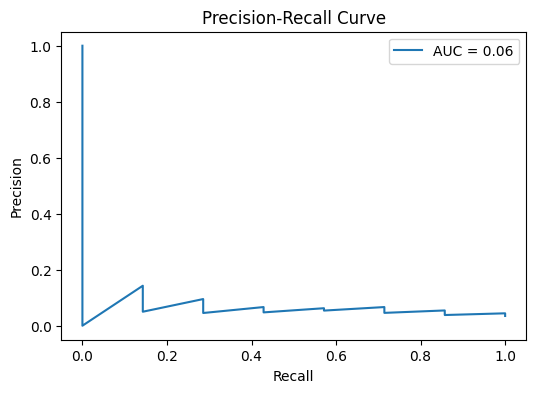

Grad-CAM
нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки): 0.0077
возраст: -0.0198
пол (1-м, 2 - ж): 0.0174
ecog: -0.0014
пмзо: -0.0051
сопутствующие. наличие: 0.0100
гипертоническая болезнь(1): 0.0150
ибс(2): -0.0288
хобл(3): 0.0040
мерц аритмия(4): 0.0095
эндокринопатии(5): 0.0065
сд(6): -0.0054
ревматоидные заболевания(7): -0.0168
гепатиты(8): 0.0018
анемия до начала лечения(9): -0.0261
гастроэнтериты(10): 0.0074
болезни мочевыводящей системы(11): -0.0167
варикозное расширение вен(12): -0.0137
т стадия: -0.0146
n стадия: 0.0245
легкие: -0.0086
печень: 0.0129
кости: -0.0014
брюшная полость: 0.0297
лу: 0.0099
надпочечники: 0.0001
плевра: 0.0097
почки: -0.0235
мягкие ткани: -0.0028
яичники: -0.0144
головной мозг: 0.0110
поджелудочная железа: -0.0016
молочная железа: -0.0202
характер метастазирования: 0.0085
стадия: 0.0019
мутация гена braf: -0.0089
индекс массы тела: -0.0111
линия иммунотерапии: 0.0088
вид ит: -0.0022
токсичность 3-4.1: 0.0114
мед

C:\Users\Таня\AppData\Local\Temp\ipykernel_4296\3625154978.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, test_samples, feature_names=feature_names, max_display=max_display, plot_type='dot', show=False)


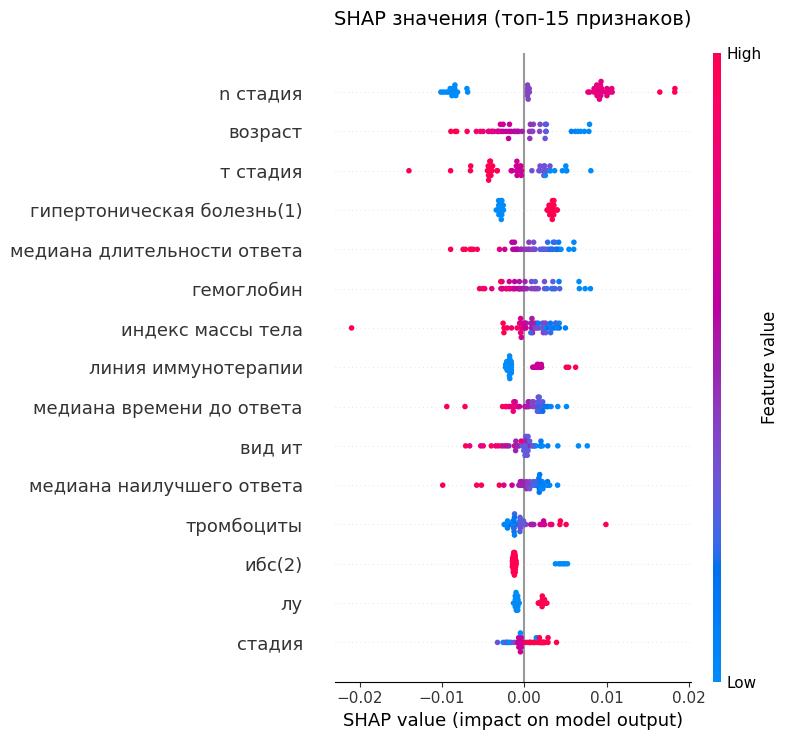

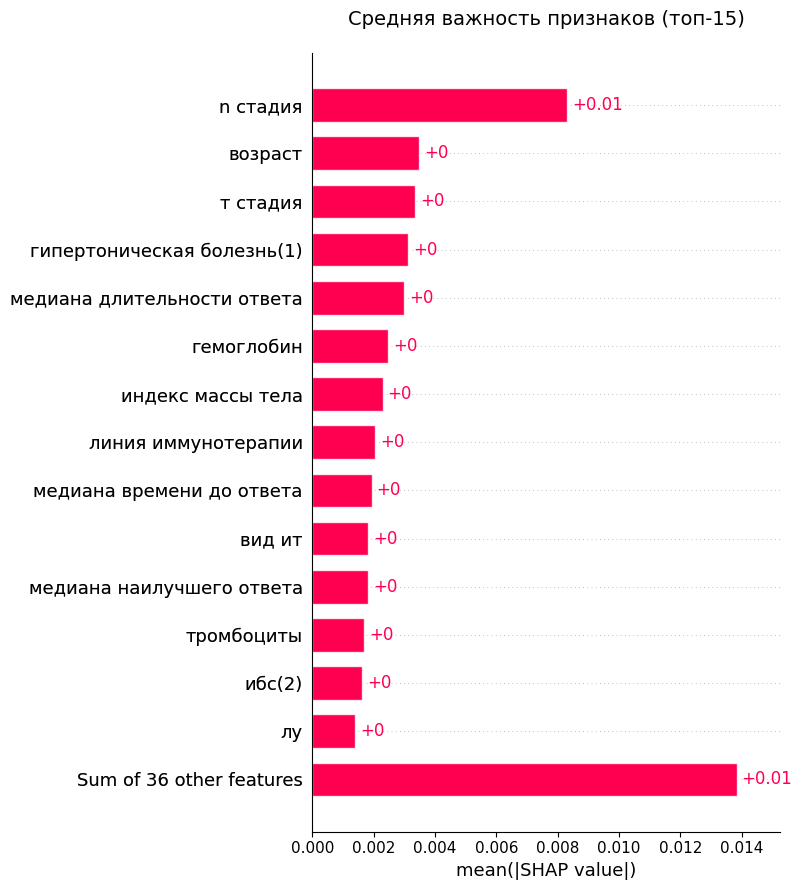


RFE
Ранжирование признаков по важности (RFE):
токсичность 3-4.1: 1
ecog: 2
анемия до начала лечения(9): 3
болезни мочевыводящей системы(11): 4
возраст: 5
медиана наилучшего ответа: 6
варикозное расширение вен(12): 7
пмзо: 8
пол (1-м, 2 - ж): 9
плевра: 10
печень: 11
мерц аритмия(4): 12
брюшная полость: 13
хобл(3): 14
индекс массы тела: 15
мягкие ткани: 16
легкие: 17
т стадия: 18
характер метастазирования: 19
медиана длительности ответа: 20
почки: 21
яичники: 22
ибс(2): 23
ревматоидные заболевания(7): 24
сд(6): 25
головной мозг: 26
креатинин: 27
надпочечники: 28
гепатиты(8): 29
стадия: 30
n стадия: 31
эндокринопатии(5): 32
кости: 33
гипертоническая болезнь(1): 34
алт: 35
вид ит: 36
поджелудочная железа: 37
гемоглобин: 38
молочная железа: 39
лу: 40
сопутствующие. наличие: 41
гастроэнтериты(10): 42
нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак жкт,5- рак шейки матки): 43
лейкоциты: 44
линия иммунотерапии: 45
тромбоциты: 46
аст: 47
общий белок: 48
медиана времени до ответ

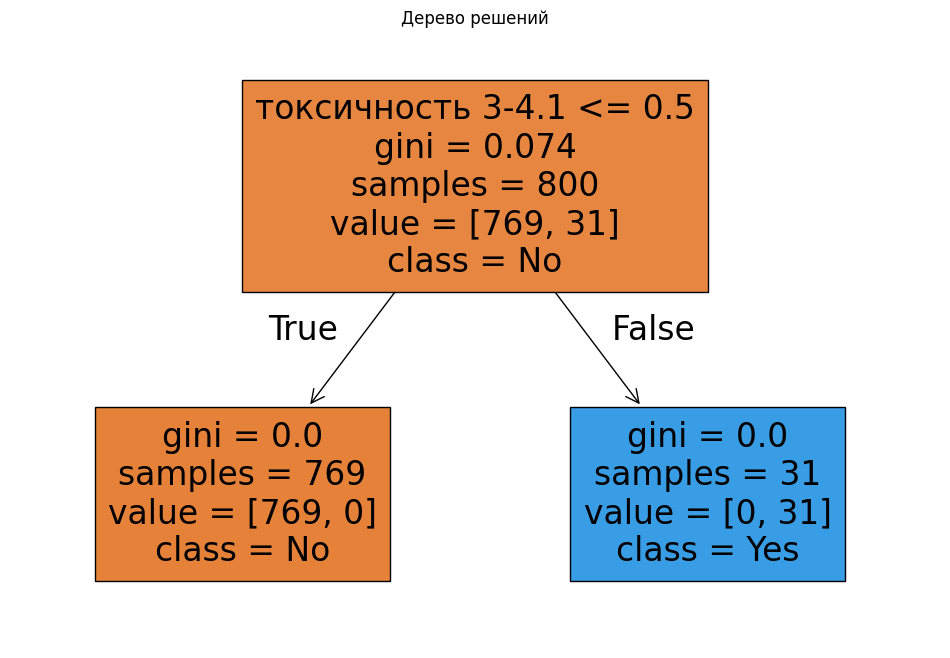

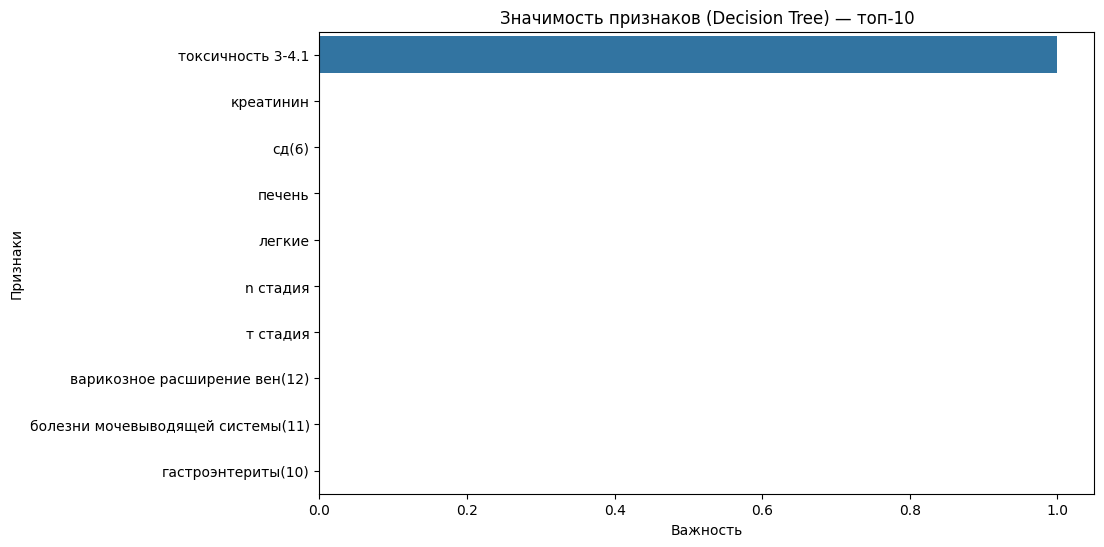


Топ-10 признаков по важности:
Признак: токсичность 3-4.1, Значимость: 1.0000
Признак: креатинин, Значимость: 0.0000
Признак: сд(6), Значимость: 0.0000
Признак: печень, Значимость: 0.0000
Признак: легкие, Значимость: 0.0000
Признак: n стадия, Значимость: 0.0000
Признак: т стадия, Значимость: 0.0000
Признак: варикозное расширение вен(12), Значимость: 0.0000
Признак: болезни мочевыводящей системы(11), Значимость: 0.0000
Признак: гастроэнтериты(10), Значимость: 0.0000


MedicalNN(
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [188]:
target = data['target_токсичность']
run_pipeline(features, target, feature_columns, 'target_токсичность', epochs=50)